In [1]:
import numpy as np
import scipy
import scipy.stats
import sklearn
import sklearn.preprocessing
import sklearn.linear_model

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

date = '9_25_20' # change this to get today's date

# Directory containing the motif scanning results.
motif_input_dir = '../motif_scanning_results/'
file_prefix = 'leiomyoma_DeCET_ATACseq_motif_scan'
output_dir = '../'

In [2]:
# Read in the names of the motifs. This is just a list of
# motif names that match the columns in the motif calling
# matrix described below.
motif_names = np.loadtxt(motif_input_dir + file_prefix + '_pos_loc4/names', dtype=str, delimiter="\t")

# From the motif names obtain the gene symbol for the
# corresponding transcription factor. The motif names
# are in the format (HOCOMOCO_TFsymbol.coverage).
TF_names = []
for motif in motif_names:
    TF_names.append(motif.replace('HOCOMOCO_','').replace('.coverage',''))

# Read in the motif calling result for each set of regions.
# The motif calling results are stored as a CSV file with
# each region corresponding to a row and the comma separated
# columns to the result for the corresponding motif following
# the order given in motif names. The value corresponds to the
# number of hits for the motif in the sequence.
count_matrix_myo = np.loadtxt(motif_input_dir + file_prefix + '_pos_loc4/coverage_data.csv', dtype=np.int, delimiter=",")
count_matrix_leio = np.loadtxt(motif_input_dir + file_prefix + '_neg_loc4/coverage_data.csv', dtype=np.int, delimiter=",")

print(count_matrix_myo.shape)
print(count_matrix_leio.shape)

# Binarize the count matrix. A value of 1 indicates the
# motif was found in the sequence and a value of 0 
# indicates that it was not
binary_myo = np.clip(count_matrix_myo, 0, 1)
binary_leio = np.clip(count_matrix_leio, 0, 1)

(768, 317)
(1250, 317)


In [3]:
## Motif enrichment

In [4]:
# Use Fisher's exact test to test for non-independence
# of the presence of a motif and the condition in which
# the sequence has higher active marks; The set of
# sequences the motif is enriched in is determined using
# the odds ratio

motif_enrichment_pvalue = [1.0 for i in range(len(motif_names))]
odds_ratio = [0.0 for i in range(len(motif_names))]
for i in range(len(motif_names)):
    table = [[len(np.where(binary_myo[:,i] == 1)[0]), len(np.where(binary_myo[:,i] == 0)[0])],
             [len(np.where(binary_leio[:,i] == 1)[0]), len(np.where(binary_leio[:,i] == 0)[0])]]
    odds_ratio[i], motif_enrichment_pvalue[i] = scipy.stats.fisher_exact(table, alternative='two-sided')

In [5]:
# Benjamini-Hochberg multiple hypothesis test correction 
alpha = 1e-3 # control FDR at this level
sorted_pvalue_index = np.argsort(motif_enrichment_pvalue)
for i in range(len(motif_enrichment_pvalue)-1, -1, -1):
    if( motif_enrichment_pvalue[sorted_pvalue_index[i]] >
        alpha*(i+1)/len(motif_enrichment_pvalue) ):
        continue
    else:
        K = i + 1
        print(K)
        break

# Get the adjusted p_value sorted by the p-value order
sorted_adj_pvalue = [motif_enrichment_pvalue[sorted_pvalue_index[i]]*(len(motif_enrichment_pvalue)/(i+1))
                     for i in range(len(motif_enrichment_pvalue))]
for i in range(len(sorted_adj_pvalue)-1, 0, -1):
    sorted_adj_pvalue[i-1] = min(sorted_adj_pvalue[i-1], sorted_adj_pvalue[i])

19


In [6]:
# TFs with motifs enriched in the regions with lower
# active histone modifications in leiomyoma
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] > 1.0):
        print("{0}\t{1:.2e}\t{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      np.log(odds_ratio[sorted_pvalue_index[i]])))

ETV4	1.16e-09	0.72
MECP2	3.98e-06	0.59
PGR	1.03e-05	0.91
ETV5	2.29e-05	0.49
ETS2	5.88e-05	0.44
IRF2	2.07e-04	inf
ZBTB17	2.07e-04	0.54
RBPJ	2.07e-04	0.51
IRF1	4.02e-04	2.24
PRDM1	4.39e-04	1.35
NR3C1	6.35e-04	0.78
E2F4	8.22e-04	0.51


In [7]:
# TFs with motifs enriched in the regions with higher
# active histone modifications in leiomyoma
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] < 1.0):
        print("{0}\t{1:.2e}\t{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      np.log(odds_ratio[sorted_pvalue_index[i]])))

TBP	1.16e-09	-0.72
HOXC9	4.97e-09	-0.93
CDX1	6.43e-09	-0.62
HOXA9	1.38e-07	-0.95
SRF	1.38e-07	-2.50
MEIS1	1.19e-06	-0.92
HOXA10	1.49e-06	-0.99


In [8]:
## Sequence based logistic regression classification 

In [9]:
# Get the class labels for each of the sequences.
class_myo = np.ones(binary_myo.shape[0], dtype=np.int8)
class_leio = np.zeros(binary_leio.shape[0], dtype=np.int8)
full_class = np.concatenate((class_leio, class_myo), axis=0)
del class_myo, class_leio

# Concatenate the binary matrices to get the full
# predictor matrix
full_binary_matrix = np.concatenate((binary_leio, binary_myo), axis=0)


In [10]:
# Use 5-fold cross validation with a grid search to choose 
# the L1 regularization parameter lambda.
# Range of values to try
lambda_list = [0.01*(i+1) for i in range(100)]
CV_reg_pair = []

n_splits = 5
skf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=True)

for l_r in lambda_list:
    # Calculate the class balanced loss and accuracy on
    # the test set for each value of lambda
    avg_loss = 0.0
    avg_CV = 0.0
    skl_loss = 0.0
    for train_index, test_index in skf.split(full_binary_matrix, full_class):
        X_train, X_test = full_binary_matrix[train_index], full_binary_matrix[test_index]
        Y_train, Y_test = full_class[train_index], full_class[test_index]
        clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_r, solver='liblinear',
                                                      class_weight='balanced').fit(X_train, Y_train)


        class_weight = len(Y_test)/(2 * np.bincount(Y_test))
        predicted = clf.predict_log_proba(X_test)
        # The loss function on the test set without the L1 regularization term
        loss = (-1.0/len(Y_test))*sum([class_weight[Y_test[i]]*((1-Y_test[i])*predicted[i,0] + Y_test[i]*predicted[i,1]) for i in range(len(Y_test))])
        avg_loss += loss/n_splits
    
        avg_CV += sklearn.metrics.balanced_accuracy_score(Y_test, clf.predict(X_test))/n_splits        

        total_count = [0.0, 0.0]
        correct_count = [0.0, 0.0]
    CV_reg_pair.append((l_r, avg_loss, avg_CV))

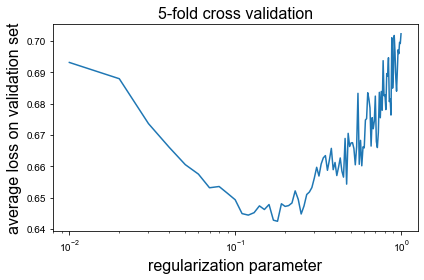

In [11]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot([CV_reg_pair[i][0] for i in range(len(CV_reg_pair))],
               [CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])

plt.xscale('log')
ax1.set_xlabel('regularization parameter',fontsize=16)
ax1.set_ylabel('average loss on validation set',fontsize=16)
plt.title('5-fold cross validation',fontsize=16)
plt.tight_layout()

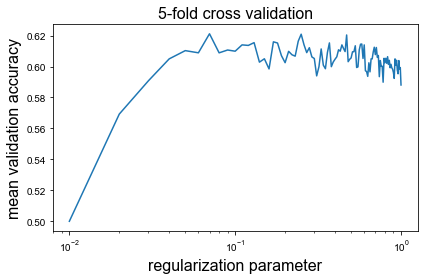

In [12]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot([CV_reg_pair[i][0] for i in range(len(CV_reg_pair))],
               [CV_reg_pair[i][2] for i in range(len(CV_reg_pair))])

plt.xscale('log')
ax1.set_xlabel('regularization parameter',fontsize=16)
ax1.set_ylabel('mean validation accuracy',fontsize=16)
plt.title('5-fold cross validation',fontsize=16)
plt.tight_layout()

In [13]:
# Select the regularization parameter that minimizes the mean
# log-loss on the test set
print(np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))]))
print(CV_reg_pair[np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])])
l_fr = CV_reg_pair[np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])][0]

17
(0.18, 0.642504867690378, 0.6151949749596809)


In [14]:
# Set l_fr = 0.19 to reproduce the results presented in Tables S4 and S5.
# Because the cross validation randomly samples from the set of sequences,
# this parameter can fluctuate some from run to run. The small fluctuations
# should not have a large effect on the final result.
l_fr = 0.19

In [15]:
# Now perform repeated random sampling and fit the
# logistic regression using the parameter found
# from the grid search. At each iteration the model
# is fit on 80% of the data and then tested on the 
# remaining 20%. The average training and test
# accuracies are reported.
avg_CV = 0.0
avg_train = 0.0
n_iter = 500
for i in range(n_iter):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(full_binary_matrix, full_class, test_size = 0.2)

    clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_fr, class_weight='balanced',
                                                  solver='liblinear').fit(X_train, Y_train)

    predicted = clf.predict_log_proba(X_test)
    
    # Get the class balanced test and training accuracies
    avg_CV += sklearn.metrics.balanced_accuracy_score(Y_test, clf.predict(X_test))/n_iter
    avg_train += sklearn.metrics.balanced_accuracy_score(Y_train, clf.predict(X_train))/n_iter
    
print("Mean CV training accuracy: ", avg_train)
print("Mean CV test accuracy    : ", avg_CV)

Mean CV training accuracy:  0.6679925216254803
Mean CV test accuracy    :  0.6097599222930288


In [16]:
# Fit the model on the entire data set. This is used
# To identify the motifs with greatest regression
# coefficients.
clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_fr, 
                                              class_weight='balanced',
                                              solver='liblinear').fit(full_binary_matrix,
                                                                      full_class)
print("Full training accuracy: ",
      sklearn.metrics.balanced_accuracy_score(full_class, clf.predict(full_binary_matrix)))

Full training accuracy:  0.6677500000000001


In [17]:
# Transcription factors with the 10 most positive
# regression coefficients (predicting lower histone
# modifications in leiomyoma)
print("Predict lower in leiomyoma")
for i in range(10):
    print("{0}\t{1:.2f}".format(TF_names[np.argsort(clf.coef_[0])[-i-1]],
                                np.sort(clf.coef_[0])[-i-1]))

Predict lower in leiomyoma
PGR	0.83
ETV4	0.54
PRDM1	0.51
MECP2	0.40
GATA4	0.36
IRF1	0.33
FOS	0.26
ETS2	0.23
DBP	0.19
REL	0.17


In [18]:
# Transcription factors with the 10 most negative
# regression coefficients (predicting higher histone
# modifications in leiomyoma)
print("Predict higher in leiomyoma")
for i in range(10):
    print("{0}\t{1:.2f}".format(TF_names[np.argsort(clf.coef_[0])[i]],
                                np.sort(clf.coef_[0])[i]))

Predict higher in leiomyoma
SRF	-1.29
HOXC9	-0.47
TBP	-0.46
HOXA9	-0.43
HOXA10	-0.38
ZNF335	-0.37
ZNF281	-0.33
CDX1	-0.33
SOX3	-0.27
ZNF563	-0.19


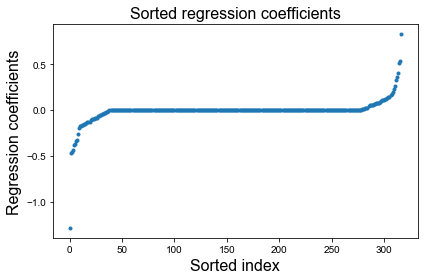

In [19]:
# Plot the regression coefficients
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot(np.sort(clf.coef_[0]),'.')

ax1.set_xlabel('Sorted index',fontsize=16)
ax1.set_ylabel('Regression coefficients',fontsize=16)
plt.title('Sorted regression coefficients',fontsize=16)
plt.tight_layout()

In [20]:
len(motif_names)

317

In [21]:
# TFs with motifs enriched in the regions with lower
# active histone modifications in leiomyoma
print("Transcription factor,Adjusted p-value,Logistic regression coefficient")
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] > 1.0):
        print("{0},{1:.2e},{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      clf.coef_[0][sorted_pvalue_index[i]]))
    

Transcription factor,Adjusted p-value,Logistic regression coefficient
ETV4,1.16e-09,0.54
MECP2,3.98e-06,0.40
PGR,1.03e-05,0.83
ETV5,2.29e-05,0.00
ETS2,5.88e-05,0.23
IRF2,2.07e-04,0.00
ZBTB17,2.07e-04,0.08
RBPJ,2.07e-04,0.11
IRF1,4.02e-04,0.33
PRDM1,4.39e-04,0.51
NR3C1,6.35e-04,0.00
E2F4,8.22e-04,0.00


In [22]:
print("Transcription factor,Adjusted p-value,Logistic regression coefficient")
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] < 1.0):
        print("{0},{1:.2e},{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      clf.coef_[0][sorted_pvalue_index[i]]))

Transcription factor,Adjusted p-value,Logistic regression coefficient
TBP,1.16e-09,-0.46
HOXC9,4.97e-09,-0.47
CDX1,6.43e-09,-0.33
HOXA9,1.38e-07,-0.43
SRF,1.38e-07,-1.29
MEIS1,1.19e-06,-0.07
HOXA10,1.49e-06,-0.38


In [23]:
import pandas as pd
# Read a metadata table for the HOCOMOCO core motif collection.
# The table can be found at:
# (https://hocomoco11.autosome.ru/human/mono?full=false)
# This table is used to obtain the consensus sequence of the motifs.
HOCOMOCO_core_table = pd.read_csv('../HOCOMOCOv11_HUMAN_mono_motifs.tsv', header=0, sep='\t')

In [24]:
HOCOMOCO_core_table.shape

(401, 9)

In [25]:
HOCOMOCO_core_table

,Model,LOGO,Transcription factor,Model length,Quality,Consensus,TF family,EntrezGene,UniProt ID
0,AHR_HUMAN.H11MO.0.B,NaN,HUMAN:AHR,9,B,dKhGCGTGh,PAS domain factors{1.2.5},196,AHR_HUMAN
1,AIRE_HUMAN.H11MO.0.C,NaN,HUMAN:AIRE,18,C,hnnGGWWnddWWGGdbWh,AIRE{5.3.1},326,AIRE_HUMAN
2,ALX1_HUMAN.H11MO.0.B,NaN,HUMAN:ALX1,12,B,vTRATYGnATTA,Paired-related HD factors{3.1.3},8092,ALX1_HUMAN
3,ANDR_HUMAN.H11MO.0.A,NaN,HUMAN:AR,18,A,WKThYYddbhTRTTTRYh,Steroid hormone receptors (NR3){2.1.1},367,ANDR_HUMAN
4,AP2A_HUMAN.H11MO.0.A,NaN,HUMAN:TFAP2A,15,A,dddSCCTGRGGShdd,AP-2{1.3.1},7020,AP2A_HUMAN
5,AP2B_HUMAN.H11MO.0.B,NaN,HUMAN:TFAP2B,10,B,GSCYGRGGRv,AP-2{1.3.1},7021,AP2B_HUMAN
6,AP2C_HUMAN.H11MO.0.A,NaN,HUMAN:TFAP2C,14,A,vddSCCTGRGGShv,AP-2{1.3.1},7022,AP2C_HUMAN
7,ARI5B_HUMAN.H11MO.0.C,NaN,HUMAN:ARID5B,13,C,nbYKnRTATTSKd,ARID-related factors{3.7.1},84159,ARI5B_HUMAN
8,ARNT_HUMAN.H11MO.0.B,NaN,HUMAN:ARNT,9,B,vdRCGTGMh,PAS domain factors{1.2.5},405,ARNT_HUMAN
9,ASCL1_HUMAN.H11MO.0.A,NaN,HUMAN:ASCL1,14,A,hnvCASCTGYYbhh,MyoD / ASC-related factors{1.2.2},429,ASCL1_HUMAN


In [26]:
for i in range(HOCOMOCO_core_table.shape[0]):
    HOCOMOCO_core_table.at[i,'Transcription factor'] = HOCOMOCO_core_table.at[i,'Transcription factor'].split(':')[1]

In [27]:
# TFs with motifs enriched in the regions with higher
# activate histone modifications in leiomyoma
print("Transcription factor,Adjusted p-value,Logistic regression coefficient, Consensus")
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] < 1.0):
        print("{0}, {1:.2e}, {2:.2f}, {3}".format(TF_names[sorted_pvalue_index[i]],
                                                   sorted_adj_pvalue[i],
                                                   clf.coef_[0][sorted_pvalue_index[i]],
                                                   HOCOMOCO_core_table.loc[HOCOMOCO_core_table.loc[:,'Transcription factor'] == TF_names[sorted_pvalue_index[i]]].loc[:,'Consensus'].values[0]))

Transcription factor,Adjusted p-value,Logistic regression coefficient, Consensus
TBP, 1.16e-09, -0.46, MbATAWAWRS
HOXC9, 4.97e-09, -0.47, hTTWATKGSh
CDX1, 6.43e-09, -0.33, hTTKAWGd
HOXA9, 1.38e-07, -0.43, dTGATTKAYdd
SRF, 1.38e-07, -1.29, hhbCCWWWTWTGGbvddd
MEIS1, 1.19e-06, -0.07, dTGATWdATddb
HOXA10, 1.49e-06, -0.38, dnYnRTTTATGh


In [28]:
# TFs with motifs enriched in the regions with lower
# activate histone modifications in leiomyoma
print("Transcription factor,Adjusted p-value,Logistic regression coefficient, Consensus")
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] > 1.0):
        print("{0}, {1:.2e}, {2:.2f}, {3}".format(TF_names[sorted_pvalue_index[i]],
                                                  sorted_adj_pvalue[i],
                                                  clf.coef_[0][sorted_pvalue_index[i]],
                                                  HOCOMOCO_core_table.loc[HOCOMOCO_core_table.loc[:,'Transcription factor'] == TF_names[sorted_pvalue_index[i]]].loc[:,'Consensus'].values[0]))

Transcription factor,Adjusted p-value,Logistic regression coefficient, Consensus
ETV4, 1.16e-09, 0.54, vdSAGGAARbd
MECP2, 3.98e-06, 0.40, SCCGGAG
PGR, 1.03e-05, 0.83, RGvACWYYbTGTdCYb
ETV5, 2.29e-05, 0.00, vddvAGGRARddvv
ETS2, 5.88e-05, 0.23, ddvdRGAARvRdv
IRF2, 2.07e-04, 0.00, nRRWvhGAAASYGAAASYvv
ZBTB17, 2.07e-04, 0.08, vndRvhGRRGGMdGRRvdd
RBPJ, 2.07e-04, 0.11, vbbSWGRGAAv
IRF1, 4.02e-04, 0.33, vRRWndGAAASWGAAAShvv
PRDM1, 4.39e-04, 0.51, RRRAGdGAAAGKdv
NR3C1, 6.35e-04, 0.00, dGdACWnAvWGTnCh
E2F4, 8.22e-04, 0.00, vddSGCGGGRvvd
